
# PyTorch Lightning Basic GAN Tutorial

* **Author:** PL team
* **License:** CC BY-SA
* **Generated:** 2022-04-28T08:05:27.455055

How to train a GAN!

Main takeaways:
1. Generator and discriminator are arbitrary PyTorch modules.
2. training_step does both the generator and discriminator training.


---
Open in [Open In Colab{height="20px" width="117px"}](https://colab.research.google.com/github/PytorchLightning/lightning-tutorials/blob/publication/.notebooks/lightning_examples/basic-gan.ipynb)

Give us a ⭐ [on Github](https://www.github.com/PytorchLightning/pytorch-lightning/)
| Check out [the documentation](https://pytorch-lightning.readthedocs.io/en/stable/)
| Join us [on Slack](https://www.pytorchlightning.ai/community)

## Setup
This notebook requires some packages besides pytorch-lightning.

In [1]:
! pip install --quiet "torchvision" "pytorch-lightning>=1.4" "torchmetrics>=0.6" "ipython[notebook]" "torch>=1.6, <1.9"

You should consider upgrading via the '/usr/bin/python3.8 -m pip install --upgrade pip' command.


In [2]:
import os

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from pytorch_lightning import LightningDataModule, LightningModule, Trainer
from pytorch_lightning.callbacks.progress import TQDMProgressBar
from torch.utils.data import DataLoader, random_split
from torchvision.datasets import MNIST

PATH_DATASETS = os.environ.get("PATH_DATASETS", ".")
BATCH_SIZE = 256 if torch.cuda.is_available() else 64
NUM_WORKERS = int(os.cpu_count() / 2)

### MNIST DataModule

Below, we define a DataModule for the MNIST Dataset. To learn more about DataModules, check out our tutorial
on them or see the [latest docs](https://pytorch-lightning.readthedocs.io/en/stable/extensions/datamodules.html).

In [3]:
class MNISTDataModule(LightningDataModule):
    def __init__(
        self,
        data_dir: str = PATH_DATASETS,
        batch_size: int = BATCH_SIZE,
        num_workers: int = NUM_WORKERS,
    ):
        super().__init__()
        self.data_dir = data_dir
        self.batch_size = batch_size
        self.num_workers = num_workers

        self.transform = transforms.Compose(
            [
                transforms.ToTensor(),
                transforms.Normalize((0.1307,), (0.3081,)),
            ]
        )

        # self.dims is returned when you call dm.size()
        # Setting default dims here because we know them.
        # Could optionally be assigned dynamically in dm.setup()
        self.dims = (1, 28, 28)
        self.num_classes = 10

    def prepare_data(self):
        # download
        MNIST(self.data_dir, train=True, download=True)
        MNIST(self.data_dir, train=False, download=True)

    def setup(self, stage=None):
        # Assign train/val datasets for use in dataloaders
        if stage == "fit" or stage is None:
            mnist_full = MNIST(self.data_dir, train=True, transform=self.transform)
            self.mnist_train, self.mnist_val = random_split(mnist_full, [55000, 5000])

        # Assign test dataset for use in dataloader(s)
        if stage == "test" or stage is None:
            self.mnist_test = MNIST(self.data_dir, train=False, transform=self.transform)

    def train_dataloader(self):
        return DataLoader(
            self.mnist_train,
            batch_size=self.batch_size,
            num_workers=self.num_workers,
        )

    def val_dataloader(self):
        return DataLoader(self.mnist_val, batch_size=self.batch_size, num_workers=self.num_workers)

    def test_dataloader(self):
        return DataLoader(self.mnist_test, batch_size=self.batch_size, num_workers=self.num_workers)

### A. Generator

In [4]:
class Generator(nn.Module):
    def __init__(self, latent_dim, img_shape):
        super().__init__()
        self.img_shape = img_shape

        def block(in_feat, out_feat, normalize=True):
            layers = [nn.Linear(in_feat, out_feat)]
            if normalize:
                layers.append(nn.BatchNorm1d(out_feat, 0.8))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers

        self.model = nn.Sequential(
            *block(latent_dim, 128, normalize=False),
            *block(128, 256),
            *block(256, 512),
            *block(512, 1024),
            nn.Linear(1024, int(np.prod(img_shape))),
            nn.Tanh(),
        )

    def forward(self, z):
        img = self.model(z)
        img = img.view(img.size(0), *self.img_shape)
        return img

### B. Discriminator

In [5]:
class Discriminator(nn.Module):
    def __init__(self, img_shape):
        super().__init__()

        self.model = nn.Sequential(
            nn.Linear(int(np.prod(img_shape)), 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 1),
            nn.Sigmoid(),
        )

    def forward(self, img):
        img_flat = img.view(img.size(0), -1)
        validity = self.model(img_flat)

        return validity

### C. GAN

#### A couple of cool features to check out in this example...

  - We use `some_tensor.type_as(another_tensor)` to make sure we initialize new tensors on the right device (i.e. GPU, CPU).
    - Lightning will put your dataloader data on the right device automatically
    - In this example, we pull from latent dim on the fly, so we need to dynamically add tensors to the right device.
    - `type_as` is the way we recommend to do this.
  - This example shows how to use multiple dataloaders in your `LightningModule`.

In [6]:
class GAN(LightningModule):
    def __init__(
        self,
        channels,
        width,
        height,
        latent_dim: int = 100,
        lr: float = 0.0002,
        b1: float = 0.5,
        b2: float = 0.999,
        batch_size: int = BATCH_SIZE,
        **kwargs,
    ):
        super().__init__()
        self.save_hyperparameters()

        # networks
        data_shape = (channels, width, height)
        self.generator = Generator(latent_dim=self.hparams.latent_dim, img_shape=data_shape)
        self.discriminator = Discriminator(img_shape=data_shape)

        self.validation_z = torch.randn(8, self.hparams.latent_dim)

        self.example_input_array = torch.zeros(2, self.hparams.latent_dim)

    def forward(self, z):
        return self.generator(z)

    def adversarial_loss(self, y_hat, y):
        return F.binary_cross_entropy(y_hat, y)

    def training_step(self, batch, batch_idx, optimizer_idx):
        imgs, _ = batch

        # sample noise
        z = torch.randn(imgs.shape[0], self.hparams.latent_dim)
        z = z.type_as(imgs)

        # train generator
        if optimizer_idx == 0:

            # generate images
            self.generated_imgs = self(z)

            # log sampled images
            sample_imgs = self.generated_imgs[:6]
            grid = torchvision.utils.make_grid(sample_imgs)
            self.logger.experiment.add_image("generated_images", grid, 0)

            # ground truth result (ie: all fake)
            # put on GPU because we created this tensor inside training_loop
            valid = torch.ones(imgs.size(0), 1)
            valid = valid.type_as(imgs)

            # adversarial loss is binary cross-entropy
            g_loss = self.adversarial_loss(self.discriminator(self(z)), valid)
            self.log("g_loss", g_loss, prog_bar=True)
            return g_loss

        # train discriminator
        if optimizer_idx == 1:
            # Measure discriminator's ability to classify real from generated samples

            # how well can it label as real?
            valid = torch.ones(imgs.size(0), 1)
            valid = valid.type_as(imgs)

            real_loss = self.adversarial_loss(self.discriminator(imgs), valid)

            # how well can it label as fake?
            fake = torch.zeros(imgs.size(0), 1)
            fake = fake.type_as(imgs)

            fake_loss = self.adversarial_loss(self.discriminator(self(z).detach()), fake)

            # discriminator loss is the average of these
            d_loss = (real_loss + fake_loss) / 2
            self.log("d_loss", d_loss, prog_bar=True)
            return d_loss

    def configure_optimizers(self):
        lr = self.hparams.lr
        b1 = self.hparams.b1
        b2 = self.hparams.b2

        opt_g = torch.optim.Adam(self.generator.parameters(), lr=lr, betas=(b1, b2))
        opt_d = torch.optim.Adam(self.discriminator.parameters(), lr=lr, betas=(b1, b2))
        return [opt_g, opt_d], []

    def on_validation_epoch_end(self):
        z = self.validation_z.type_as(self.generator.model[0].weight)

        # log sampled images
        sample_imgs = self(z)
        grid = torchvision.utils.make_grid(sample_imgs)
        self.logger.experiment.add_image("generated_images", grid, self.current_epoch)

In [7]:
dm = MNISTDataModule()
model = GAN(*dm.size())
trainer = Trainer(
    accelerator="auto",
    devices=1 if torch.cuda.is_available() else None,  # limiting got iPython runs
    max_epochs=5,
    callbacks=[TQDMProgressBar(refresh_rate=20)],
)
trainer.fit(model, dm)

/home/AzDevOps_azpcontainer/.local/lib/python3.8/site-packages/pytorch_lightning/core/datamodule.py:149: LightningDeprecationWarning: DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.
  rank_zero_deprecation("DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.")
/home/AzDevOps_azpcontainer/.local/lib/python3.8/site-packages/pytorch_lightning/core/datamodule.py:158: LightningDeprecationWarning: DataModule property `size` was deprecated in v1.5 and will be removed in v1.7.
  rank_zero_deprecation("DataModule property `size` was deprecated in v1.5 and will be removed in v1.7.")
/home/AzDevOps_azpcontainer/.local/lib/python3.8/site-packages/pytorch_lightning/core/datamodule.py:144: LightningDeprecationWarning: DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.
  rank_zero_deprecation("DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.")
GPU available: True, used: True


TPU available: False, using: 0 TPU cores


IPU available: False, using: 0 IPUs


HPU available: False, using: 0 HPUs


/home/AzDevOps_azpcontainer/.local/lib/python3.8/site-packages/pytorch_lightning/trainer/configuration_validator.py:131: UserWarning: You passed in a `val_dataloader` but have no `validation_step`. Skipping val loop.
  rank_zero_warn("You passed in a `val_dataloader` but have no `validation_step`. Skipping val loop.")


  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting /__w/1/s/.datasets/MNIST/raw/train-images-idx3-ubyte.gz to /__w/1/s/.datasets/MNIST/raw


  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting /__w/1/s/.datasets/MNIST/raw/train-labels-idx1-ubyte.gz to /__w/1/s/.datasets/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting /__w/1/s/.datasets/MNIST/raw/t10k-images-idx3-ubyte.gz to /__w/1/s/.datasets/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting /__w/1/s/.datasets/MNIST/raw/t10k-labels-idx1-ubyte.gz to /__w/1/s/.datasets/MNIST/raw

Processing...


/home/AzDevOps_azpcontainer/.local/lib/python3.8/site-packages/torchvision/datasets/mnist.py:502: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:143.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)
Missing logger folder: /__w/1/s/lightning_logs


Done!


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]



  | Name          | Type          | Params | In sizes | Out sizes     
----------------------------------------------------------------------------
0 | generator     | Generator     | 1.5 M  | [2, 100] | [2, 1, 28, 28]
1 | discriminator | Discriminator | 533 K  | ?        | ?             
----------------------------------------------------------------------------
2.0 M     Trainable params
0         Non-trainable params
2.0 M     Total params
8.174     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

In [8]:
# Start tensorboard.
%load_ext tensorboard
%tensorboard --logdir lightning_logs/

## Congratulations - Time to Join the Community!

Congratulations on completing this notebook tutorial! If you enjoyed this and would like to join the Lightning
movement, you can do so in the following ways!

### Star [Lightning](https://github.com/PyTorchLightning/pytorch-lightning) on GitHub
The easiest way to help our community is just by starring the GitHub repos! This helps raise awareness of the cool
tools we're building.

### Join our [Slack](https://www.pytorchlightning.ai/community)!
The best way to keep up to date on the latest advancements is to join our community! Make sure to introduce yourself
and share your interests in `#general` channel


### Contributions !
The best way to contribute to our community is to become a code contributor! At any time you can go to
[Lightning](https://github.com/PyTorchLightning/pytorch-lightning) or [Bolt](https://github.com/PyTorchLightning/lightning-bolts)
GitHub Issues page and filter for "good first issue".

* [Lightning good first issue](https://github.com/PyTorchLightning/pytorch-lightning/issues?q=is%3Aopen+is%3Aissue+label%3A%22good+first+issue%22)
* [Bolt good first issue](https://github.com/PyTorchLightning/lightning-bolts/issues?q=is%3Aopen+is%3Aissue+label%3A%22good+first+issue%22)
* You can also contribute your own notebooks with useful examples !

### Great thanks from the entire Pytorch Lightning Team for your interest !

[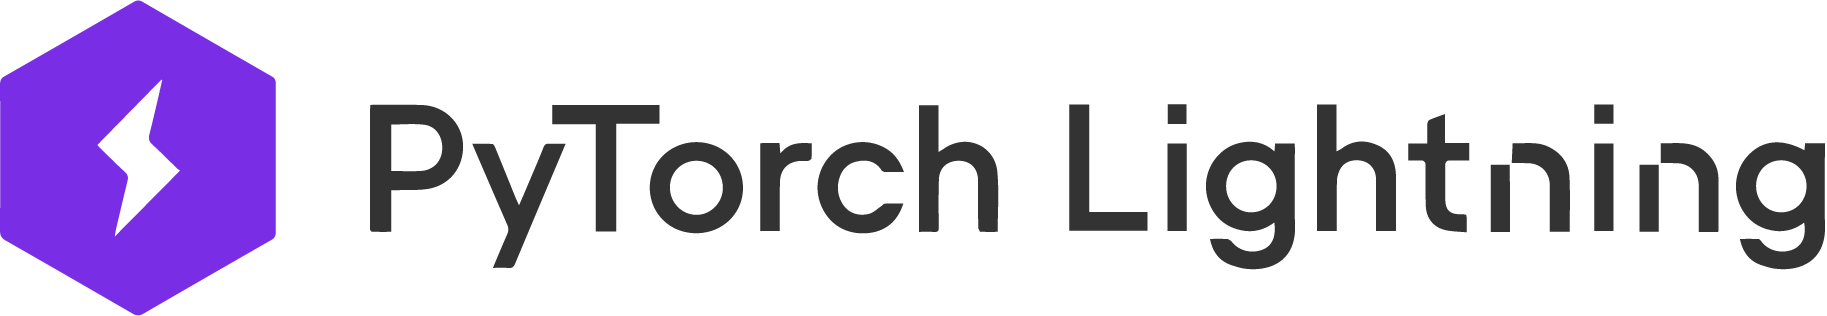{height="60px" width="240px"}](https://pytorchlightning.ai)